In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import plotly.graph_objects as go

# UN CLIMATE EQUITY & ACCOUNTABILITY DESIGN FRAMEWORK
UN_COLORS = {
    # Foundation
    'slate_grey': '#000000',
    'un_blue': '#009EDB',
    
    # Emissions Gradient (Income Groups)
    'high_income': '#C0392B',      # Rust/Danger
    'upper_middle': '#F1C40F',     # Mustard
    'lower_middle': '#1ABC9C',     # Teal
    'low_income': '#16A085',       # Soft Teal
    
    # Action Binary (Colorblind-safe)
    'negative': '#D35400',         # Vermilion (increases/bad)
    'positive': '#1ABC9C',         # Emerald (decreases/good)
    
    # Trade/Production-Consumption
    'importer': '#2C3E50',         # Dark Blue
    'exporter': '#C0392B',         # Rust Orange
}

# Income Group Color Palette (ordered)
INCOME_COLORS = [
    UN_COLORS['high_income'],
    UN_COLORS['upper_middle'],
    UN_COLORS['lower_middle'],
    UN_COLORS['low_income']
]

# 1. LOAD DATA
df = pd.read_csv('cleaned_co2_data_enriched.csv')

# Set UN Design Framework Styling
sns.set_theme(style="white")
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = UN_COLORS['slate_grey']
plt.rcParams['axes.labelcolor'] = UN_COLORS['slate_grey']
plt.rcParams['text.color'] = UN_COLORS['slate_grey']
plt.rcParams['xtick.color'] = UN_COLORS['slate_grey']
plt.rcParams['ytick.color'] = UN_COLORS['slate_grey']
plt.rcParams['grid.color'] = '#ECEFF1'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 11

# --- DATA PREPARATION ---

# Global Data
global_df = df.groupby('Year').sum(numeric_only=True).reset_index()

# Decadal Data (Filtered for 1950s-2010s)
global_df['Decade'] = (global_df['Year'] // 10) * 10
# Include 1940s in calculation to get correct growth for 1950s
decade_df_calc = global_df[global_df['Year'] >= 1940].groupby('Decade')['CO2 Emissions'].sum().reset_index()
decade_df_calc['Growth_Rate'] = decade_df_calc['CO2 Emissions'].pct_change() * 100
# Filter for final display
decade_df = decade_df_calc[(decade_df_calc['Decade'] >= 1950) & (decade_df_calc['Decade'] < 2020)].copy()

# Top 20 Countries
countries_2023 = df[df['Year'] == 2023].copy()
top_20 = countries_2023.sort_values('CO2 Emissions', ascending=False).head(20)
top_20['Cumulative_Pct'] = top_20['CO2 Emissions'].cumsum() / countries_2023['CO2 Emissions'].sum() * 100

# Sources Data
sources_cols = ['Coal CO2 Emissions', 'Oil CO2 Emissions', 'Gas CO2 Emissions',
           'Cement CO2 Emissions', 'Flaring CO2 Emissions', 'Land Use Change CO2']
# UPDATED LINE BELOW
sources_labels = ['Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Land Use Change']
global_sources = df.groupby('Year')[sources_cols].sum().reset_index()

# Temp Change Data
temp_cols = ['Temperature Change From CO2', 'Temperature Change From Methane', 'Temperature Change From Nitrous Oxide']
countries_2023['Total_Temp_Change'] = countries_2023[temp_cols].sum(axis=1)
top_temp = countries_2023.sort_values('Total_Temp_Change', ascending=False).head(10)

# Define Consistent Colors
source_colors = sns.color_palette("Spectral", len(sources_labels))
color_map = dict(zip(sources_labels, source_colors))

# 1. Which countries should pay climate taxes and which countries should be paid

## What is the cumulative CO₂ burden by income group since 1850?

In [39]:
# Filter historical data from 1850 onwards
df_historical = df[df['Year'] >= 1850].copy()

# Calculate cumulative emissions by income group
cumulative_by_income = df_historical.groupby('Income Group')['CO2 Emissions'].sum().sort_values(ascending=False)

# Convert to Gigatons
cumulative_gt = cumulative_by_income / 1000

# Calculate percentages
total_cumulative = cumulative_gt.sum()
percentages = (cumulative_gt / total_cumulative * 100)

# Create figure
fig = go.Figure()

# Map income groups to UN colors
income_color_map = {
    'High Income': UN_COLORS['high_income'],
    'Upper-Middle Income': UN_COLORS['upper_middle'],
    'Lower-Middle Income': UN_COLORS['lower_middle'],
    'Low Income': UN_COLORS['low_income']
}
colors = [income_color_map.get(group, UN_COLORS['slate_grey']) for group in cumulative_gt.index]

# Add bar chart
fig.add_trace(go.Bar(
    x=cumulative_gt.index,
    y=cumulative_gt.values,
    text=[f'{val:.1f} Gt<br>({pct:.1f}%)' for val, pct in zip(cumulative_gt.values, percentages.values)],
    textposition='outside',
    marker=dict(
        color=colors,
        line=dict(color=UN_COLORS['slate_grey'], width=1.5)
    ),
    hovertemplate='<b>%{x}</b><br>Cumulative Emissions: %{y:.1f} Gt<br>Share: %{customdata:.1f}%<extra></extra>',
    customdata=percentages.values,
    showlegend=False
))

# Update layout
fig.update_layout(
    title=dict(
        text='Cumulative CO₂ Burden by Income Group (1850-2023)<br><sub>"Who Filled Up The Carbon Budget?"</sub>',
        font=dict(size=22, color=UN_COLORS['slate_grey'], family='Arial'),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='Income Group',
        tickfont=dict(size=13, color=UN_COLORS['slate_grey']),
        showgrid=False
    ),
    yaxis=dict(
        title='Cumulative CO₂ Emissions (Gigatons)',
        tickfont=dict(size=12, color=UN_COLORS['slate_grey']),
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=0.5
    ),
    plot_bgcolor='white',
    width=1000,
    height=600,
    margin=dict(l=80, r=60, t=120, b=80)
)

# Save and show
fig.show()

## Which 20 countries account for 80% of global emissions

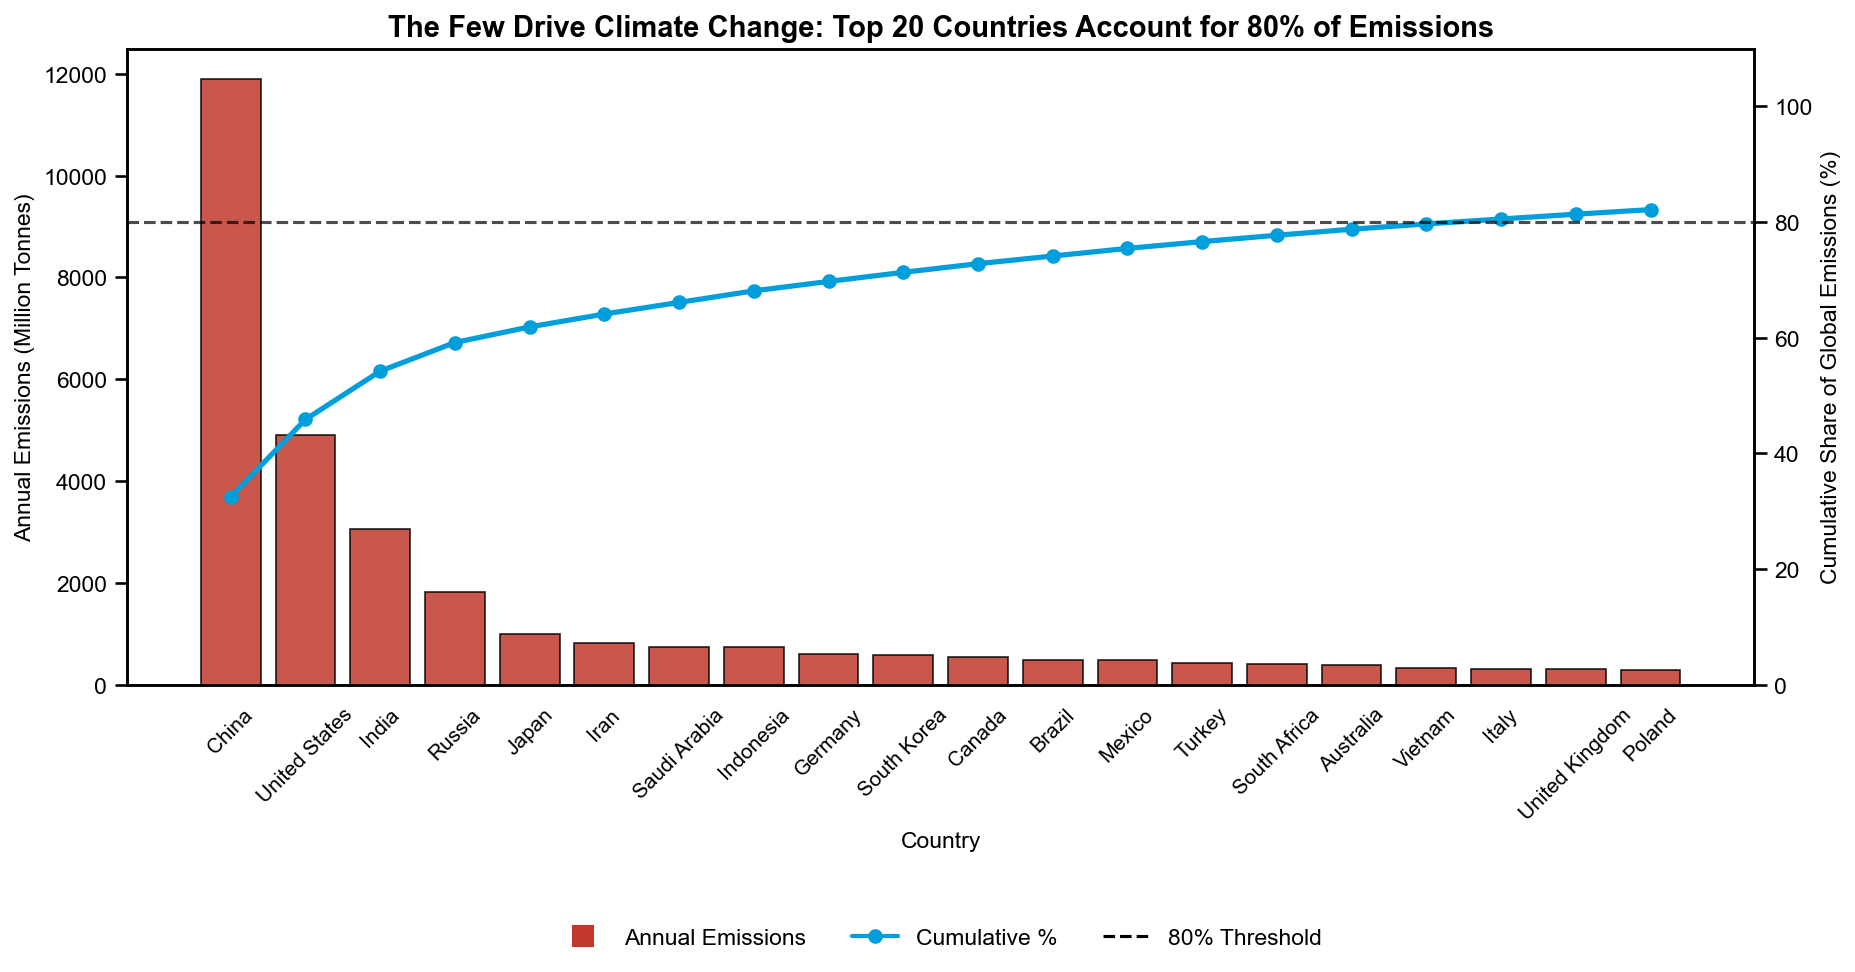

In [40]:
fig, ax1 = plt.subplots(figsize=(14, 8))
# Primary Axis (Bar Chart) - Use Rust for high emissions
bars = ax1.bar(top_20['Country'], top_20['CO2 Emissions'], color=UN_COLORS['high_income'], 
               alpha=0.85, edgecolor=UN_COLORS['slate_grey'], linewidth=0.8)
ax1.set_ylabel('Annual Emissions (Million Tonnes)', color=UN_COLORS['slate_grey'])
ax1.set_xlabel('Country', color=UN_COLORS['slate_grey'])
ax1.tick_params(axis='x', rotation=45, labelsize=10, colors=UN_COLORS['slate_grey'])
ax1.tick_params(axis='y', colors=UN_COLORS['slate_grey'])
ax1.grid(False)
# Secondary Axis (Line Chart) - Use UN Blue
ax2 = ax1.twinx()
ax2.plot(range(len(top_20)), top_20['Cumulative_Pct'].values, color=UN_COLORS['un_blue'], 
         marker='o', linewidth=2.5, markersize=6)
ax2.set_ylabel('Cumulative Share of Global Emissions (%)', color=UN_COLORS['slate_grey'])
ax2.set_ylim(0, 110)
ax2.tick_params(axis='y', colors=UN_COLORS['slate_grey'])
ax2.grid(False)
# Threshold Line
ax2.axhline(80, color=UN_COLORS['slate_grey'], linestyle='--', linewidth=1.5, alpha=0.7)
# Custom Unified Legend
handle_bar = mlines.Line2D([], [], color=UN_COLORS['high_income'], marker='s', linestyle='None', 
                           markersize=10, label='Annual Emissions')
handle_line = mlines.Line2D([], [], color=UN_COLORS['un_blue'], marker='o', linewidth=2, label='Cumulative %')
handle_threshold = mlines.Line2D([], [], color=UN_COLORS['slate_grey'], linestyle='--', linewidth=1.5, label='80% Threshold')
ax1.legend(handles=[handle_bar, handle_line, handle_threshold],
           loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=3, frameon=False)
plt.title('The Few Drive Climate Change: Top 20 Countries Account for 80% of Emissions', 
          fontsize=14, fontweight='bold', color=UN_COLORS['slate_grey'])
plt.subplots_adjust(bottom=0.35)
plt.show()

## How can we quantify historical emissions debt and climate reparations?

In [41]:
latest_year = df['Year'].max()
df_latest = df[df['Year'] == latest_year].copy()


# Define the desired order for plotting and display (High to Low Income)
ordered_groups = ['High Income', 'Upper-Middle Income', 'Lower-Middle Income', 'Low Income']

# Calculate cumulative emissions by income group
cumulative_by_income = df.groupby('Income Group')['CO2 Emissions'].sum()
total_cumulative = cumulative_by_income.sum()
cumulative_percentage = (cumulative_by_income / total_cumulative * 100)

# Get population share
population_by_income = df_latest.groupby('Income Group')['Population'].sum()
total_population = population_by_income.sum()
population_percentage = (population_by_income / total_population * 100)

# Calculate "fair share" vs actual emissions
fair_share = (population_percentage / 100) * total_cumulative
emissions_debt = cumulative_by_income - fair_share

# Reindex the series to enforce the desired order for plotting
cumulative_by_income_ordered = cumulative_by_income.reindex(ordered_groups)
fair_share_ordered = fair_share.reindex(ordered_groups)
all_groups_ordered = list(cumulative_by_income_ordered.index)


# Create visualization
fig = go.Figure()

# Actual emissions - Use Rust color
fig.add_trace(go.Bar(
    name='Actual Historical Emissions',
    x=all_groups_ordered,
    y=cumulative_by_income_ordered.values,
    marker=dict(color=UN_COLORS['high_income'], opacity=0.85, line=dict(color='white', width=2)),
    text=[f'{v:,.0f}' for v in cumulative_by_income_ordered.values],
    textposition='outside',
    textfont=dict(size=11, color=UN_COLORS['slate_grey']),
))

# Fair share - Use Teal color
fig.add_trace(go.Bar(
    name='Fair Share (based on population)',
    x=all_groups_ordered,
    y=fair_share_ordered.values,
    marker=dict(color=UN_COLORS['lower_middle'], opacity=0.85, line=dict(color='white', width=2)),
    text=[f'{v:,.0f}' for v in fair_share_ordered.values],
    textposition='inside',
    textfont=dict(size=11, color='white'),
    textangle=0,
))

fig.update_layout(
    title=dict(
        text='Historical Emissions Debt: Actual vs Fair Share<br><sub>Climate Reparations Quantified by Income Group</sub>',
        font=dict(size=18, color=UN_COLORS['slate_grey'], family='Arial'),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='Income Group',
        tickfont=dict(size=12, color=UN_COLORS['slate_grey']),
        showgrid=False,
        # *** FIX for label order: set categoryorder and categoryarray ***
        categoryorder='array',
        categoryarray=ordered_groups
    ),
    yaxis=dict(title='Cumulative CO₂ Emissions (Million Tons)', tickfont=dict(size=11, color=UN_COLORS['slate_grey']),
               showgrid=True, gridcolor='lightgray', gridwidth=0.5),
    barmode='group',
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=True,
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5, font=dict(size=12)),
    height=600,
    width=1000,
    margin=dict(t=130, b=80, l=80, r=50)
)
fig.show()

# Setting Net Zero Targets for Countries

## Which countries should reach net-zero by 2040, 2050, vs 2060?

Analyzing data for year: 2023


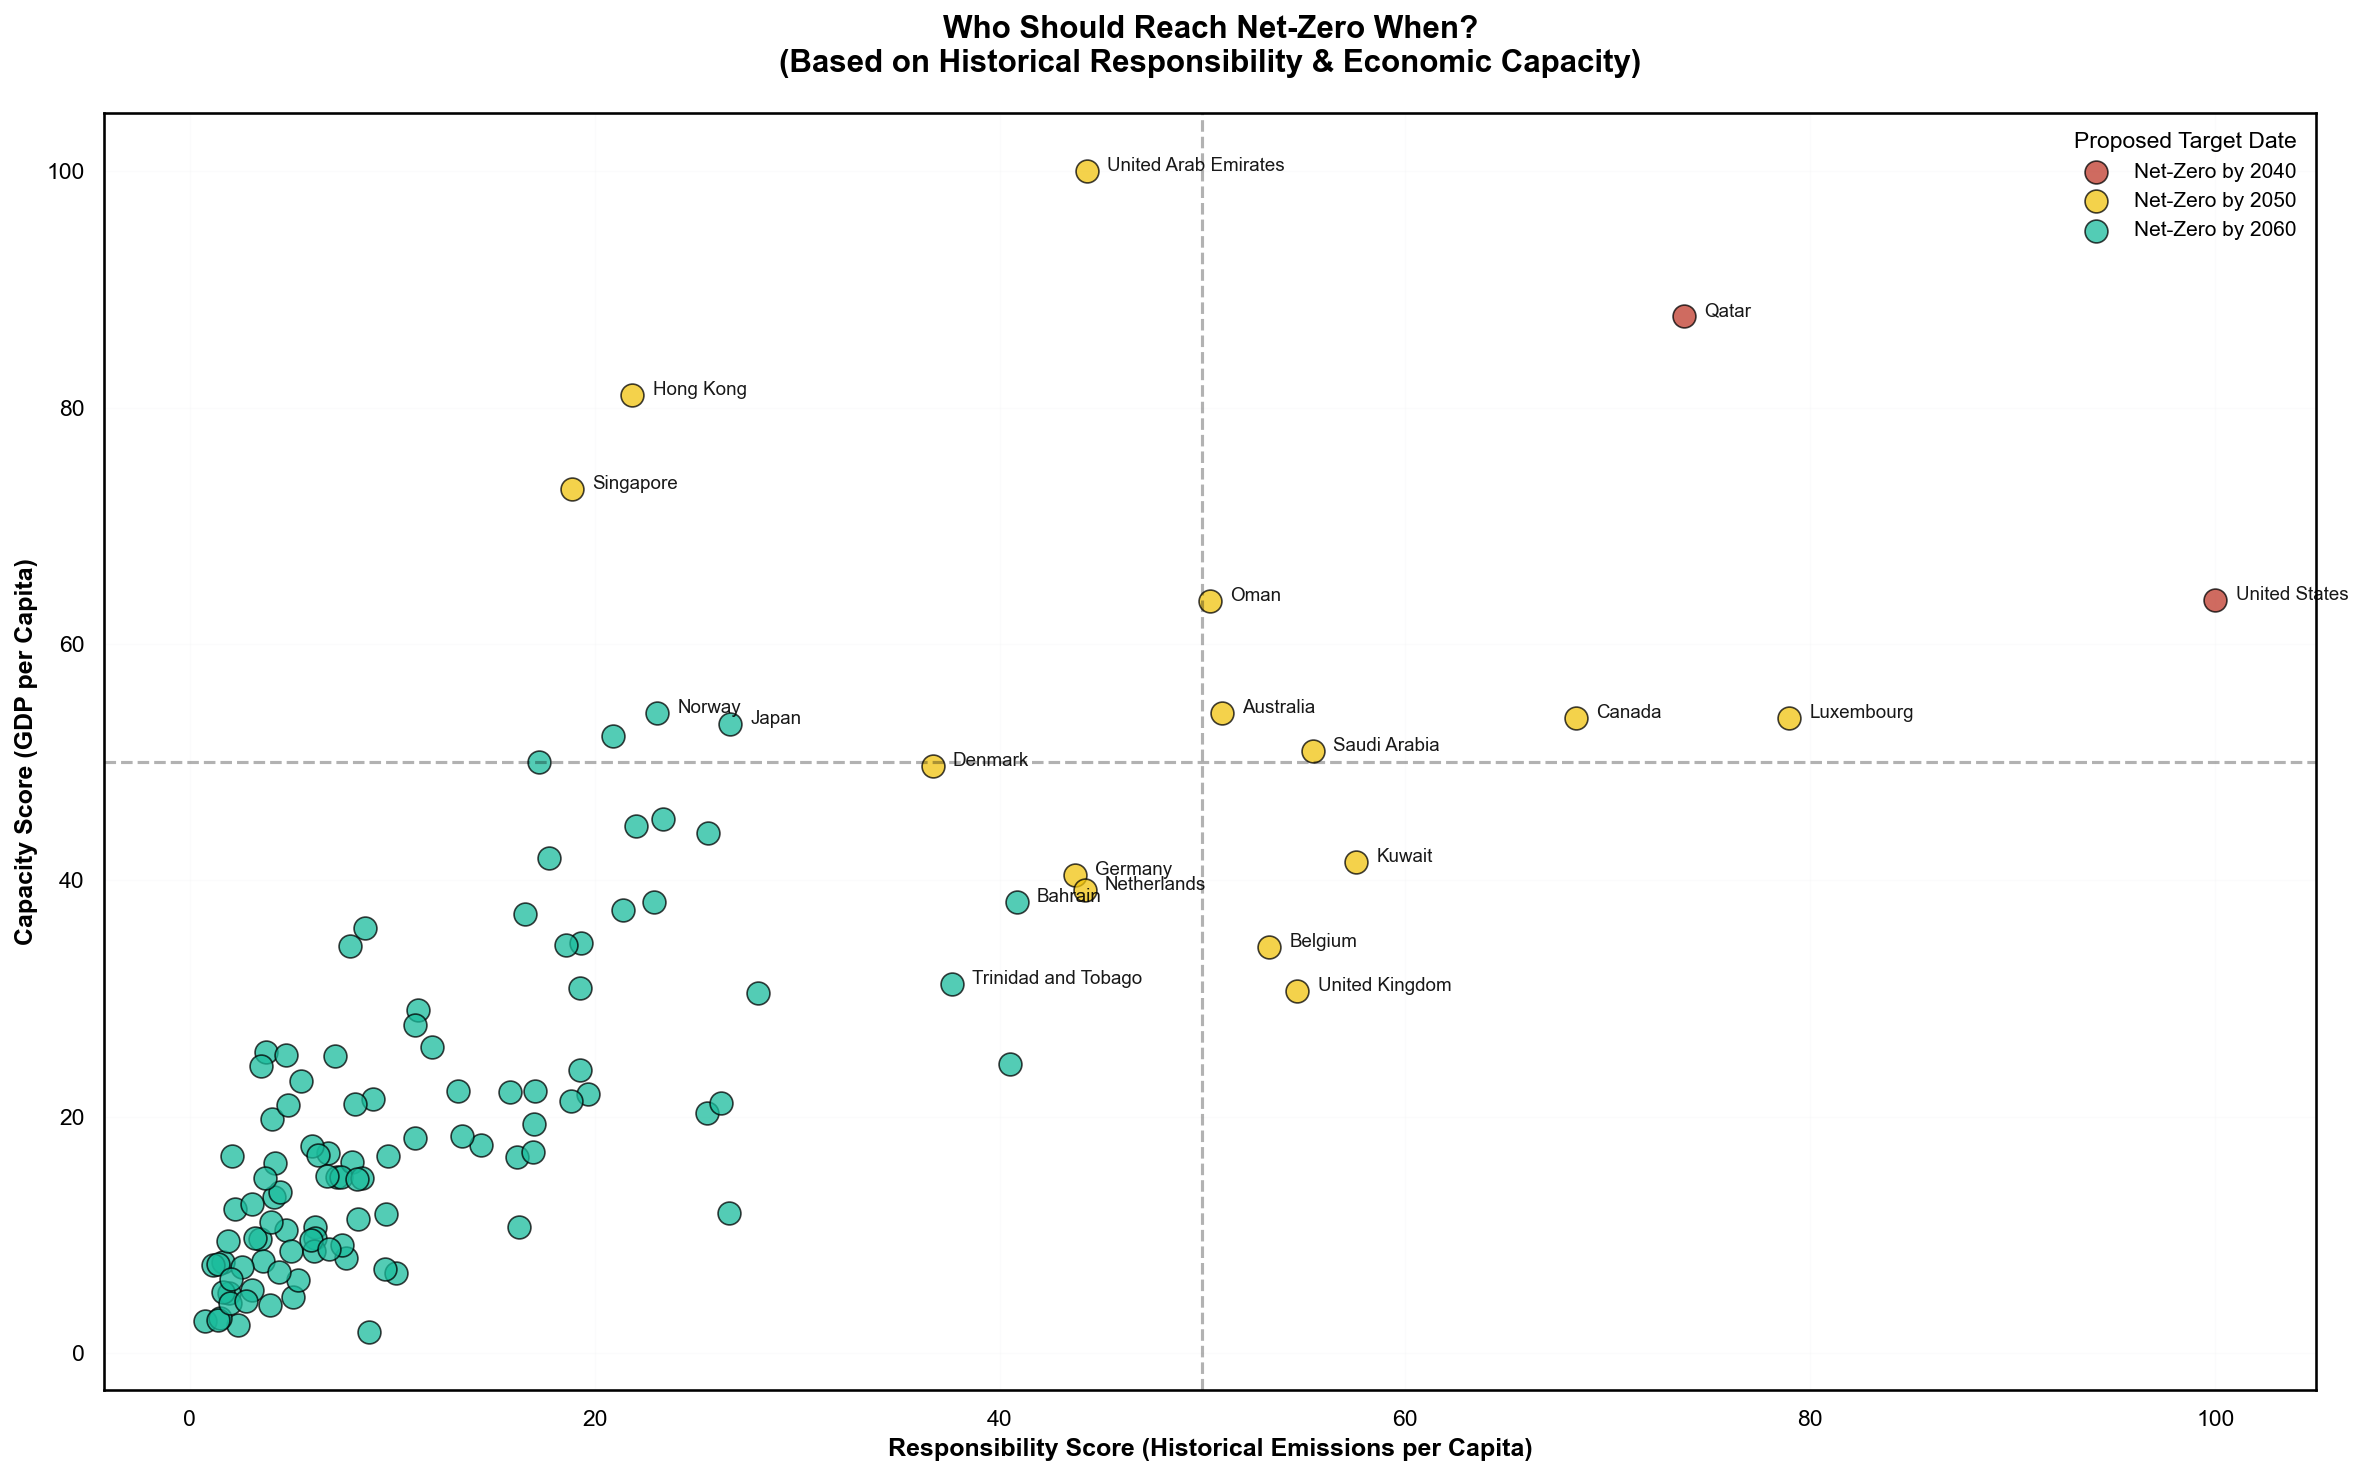

In [42]:
if 'latest_year' not in locals():
    latest_year = df[df['CO2 Emissions'].notna()]['Year'].max()
print(f"Analyzing data for year: {latest_year}")

# Create a copy of the data for the latest year
latest_data = df[df['Year'] == latest_year].copy()

# Filter for rows that actually have the necessary metrics
latest_data = latest_data[
    (latest_data['Population'].notna()) & 
    (latest_data['Gross Domestic Product'].notna()) & 
    (latest_data['CO2 Emissions'].notna())
]

# --- 2. Calculate Metrics (The Fix) ---
# FIX: Convert CO2 from Megatonnes (Mt) to Tonnes (* 1e6) for per capita calculations
# This ensures the numbers are roughly 1-20 tonnes, not 0.000001
latest_data['GDP_per_capita'] = latest_data['Gross Domestic Product'] / latest_data['Population']
latest_data['Emissions_per_capita'] = (latest_data['CO2 Emissions'] * 1_000_000) / latest_data['Population']

# Calculate cumulative emissions per capita (Historical Responsibility)
# We also convert cumulative emissions to Tonnes here for consistency
cumulative_emissions = df.groupby('Country')['CO2 Emissions'].sum() * 1_000_000
cumulative_population = df.groupby('Country')['Population'].mean() 
cumulative_per_capita = cumulative_emissions / cumulative_population.replace(0, np.nan)

# Merge data
netzero_analysis = latest_data[['Country', 'Income Group', 'GDP_per_capita', 'Emissions_per_capita']].copy()
netzero_analysis['Cumulative_per_capita'] = netzero_analysis['Country'].map(cumulative_per_capita)

# Drop countries missing history data
netzero_analysis = netzero_analysis.dropna()

# --- 3. Scoring & Normalization ---
# Normalize scores to 0-100 scale relative to the max value in the dataset
netzero_analysis['Capacity_Score'] = (netzero_analysis['GDP_per_capita'] / netzero_analysis['GDP_per_capita'].max()) * 100
netzero_analysis['Responsibility_Score'] = (netzero_analysis['Cumulative_per_capita'] / netzero_analysis['Cumulative_per_capita'].max()) * 100

# Calculate Combined Score (Weighted: 60% Responsibility, 40% Capacity)
netzero_analysis['Combined_Score'] = (netzero_analysis['Responsibility_Score'] * 0.6 + 
                                      netzero_analysis['Capacity_Score'] * 0.4)

# Assign Targets
def assign_target(score):
    if score >= 70: return '2040'
    elif score >= 40: return '2050'
    else: return '2060'

netzero_analysis['NetZero_Target'] = netzero_analysis['Combined_Score'].apply(assign_target)

# --- 4. Filtering for Visualization ---
# FIX: Now that units are in Tonnes, > 1.0 is a reasonable filter (1 ton per person)
# This removes very small island nations or data errors, but keeps major economies
netzero_viz = netzero_analysis[netzero_analysis['Emissions_per_capita'] > 1.0].copy()

# Safety check
if len(netzero_viz) == 0:
    print("Warning: Filter is too strict. Resetting to show top 50 emitters.")
    netzero_viz = netzero_analysis.nlargest(50, 'Combined_Score')

# --- 5. Visualization ---
fig, ax = plt.subplots(figsize=(16, 10))

# UN Colors: 2040 (urgent) = Rust, 2050 (standard) = Mustard, 2060 (lenient) = Teal
colors_map = {
    '2040': UN_COLORS['high_income'],     # Rust - most urgent
    '2050': UN_COLORS['upper_middle'],    # Mustard - standard
    '2060': UN_COLORS['lower_middle']     # Teal - lenient
}

# Plot scatter points
for target_year in sorted(netzero_viz['NetZero_Target'].unique()):
    target_data = netzero_viz[netzero_viz['NetZero_Target'] == target_year]
    ax.scatter(target_data['Responsibility_Score'], target_data['Capacity_Score'],
               c=colors_map.get(target_year, UN_COLORS['slate_grey']), 
               label=f'Net-Zero by {target_year}', 
               alpha=0.75, s=120, edgecolors=UN_COLORS['slate_grey'], linewidth=0.8)

# Annotate top countries
# We annotate the top 15 by combined score, plus a few specific major economies if interested
top_countries = netzero_viz.nlargest(20, 'Combined_Score')
for _, row in top_countries.iterrows():
    ax.text(row['Responsibility_Score']+1, row['Capacity_Score'], row['Country'], 
            fontsize=9, alpha=0.9, fontweight='medium', color=UN_COLORS['slate_grey'])

# Formatting
ax.set_xlabel('Responsibility Score (Historical Emissions per Capita)', fontsize=12, fontweight='bold')
ax.set_ylabel('Capacity Score (GDP per Capita)', fontsize=12, fontweight='bold')
ax.set_title('Who Should Reach Net-Zero When?\n(Based on Historical Responsibility & Economic Capacity)', 
             fontsize=15, fontweight='bold', pad=20)

# Add quadrant lines for context
ax.axhline(y=50, color=UN_COLORS['slate_grey'], linestyle='--', alpha=0.3)
ax.axvline(x=50, color=UN_COLORS['slate_grey'], linestyle='--', alpha=0.3)

ax.legend(title="Proposed Target Date", fontsize=10, title_fontsize=11, frameon=False)
ax.grid(True, alpha=0.2, color='#ECEFF1')

plt.tight_layout()
plt.show()

# Which emission source should be reduced

## In 2023, what percentage of global emissions comes from each source?

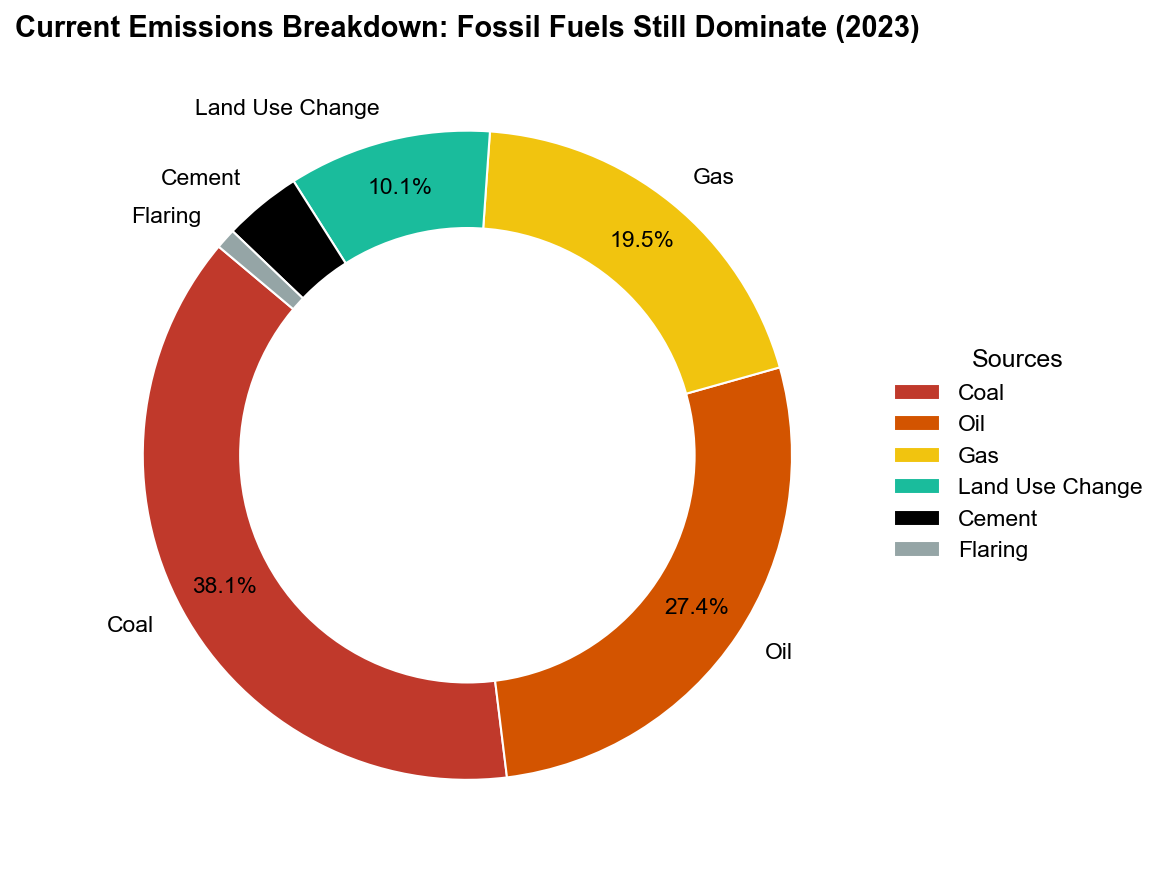

In [43]:
source_color_map_un = {
    'Coal': UN_COLORS['high_income'],      # Rust - historical villain
    'Oil': UN_COLORS['negative'],          # Dark Orange
    'Gas': UN_COLORS['upper_middle'],      # Mustard
    'Cement': UN_COLORS['slate_grey'],     # Slate Grey
    'Flaring': '#95A5A6',                  # Light Grey
    'Land Use Change': UN_COLORS['lower_middle']  # Teal
}

plt.figure(figsize=(10, 6))
latest_sources = global_sources[global_sources['Year'] == 2023][sources_cols].T
latest_sources.columns = ['Value']
latest_sources.index = sources_labels # Applies "Land Use Change" label
latest_sources = latest_sources.sort_values('Value', ascending=False)
pie_labels = latest_sources.index
# Use same UN color palette as Cell 16
pie_colors = [source_color_map_un[l] for l in pie_labels]
wedges, texts, autotexts = plt.pie(latest_sources['Value'], labels=pie_labels,
                                   autopct='%1.1f%%', startangle=140,
                                   colors=pie_colors, pctdistance=0.85,
                                   textprops={'color': UN_COLORS['slate_grey'], "fontsize": 11})


plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))

values = [38.1, 27.4, 19.5, 10.1, 3.9, 1.0]

for i, autotext in enumerate(autotexts):
    # Hide tiny labels (< 2%)
    if values[i] < 2.0:
        autotext.set_visible(False)

plt.title('Current Emissions Breakdown: Fossil Fuels Still Dominate (2023)', fontsize=14, fontweight='bold')
plt.legend(wedges, pie_labels, title="Sources", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), frameon=False)
plt.tight_layout()
plt.show()

## Which countries transitioned away from coal most successfully?

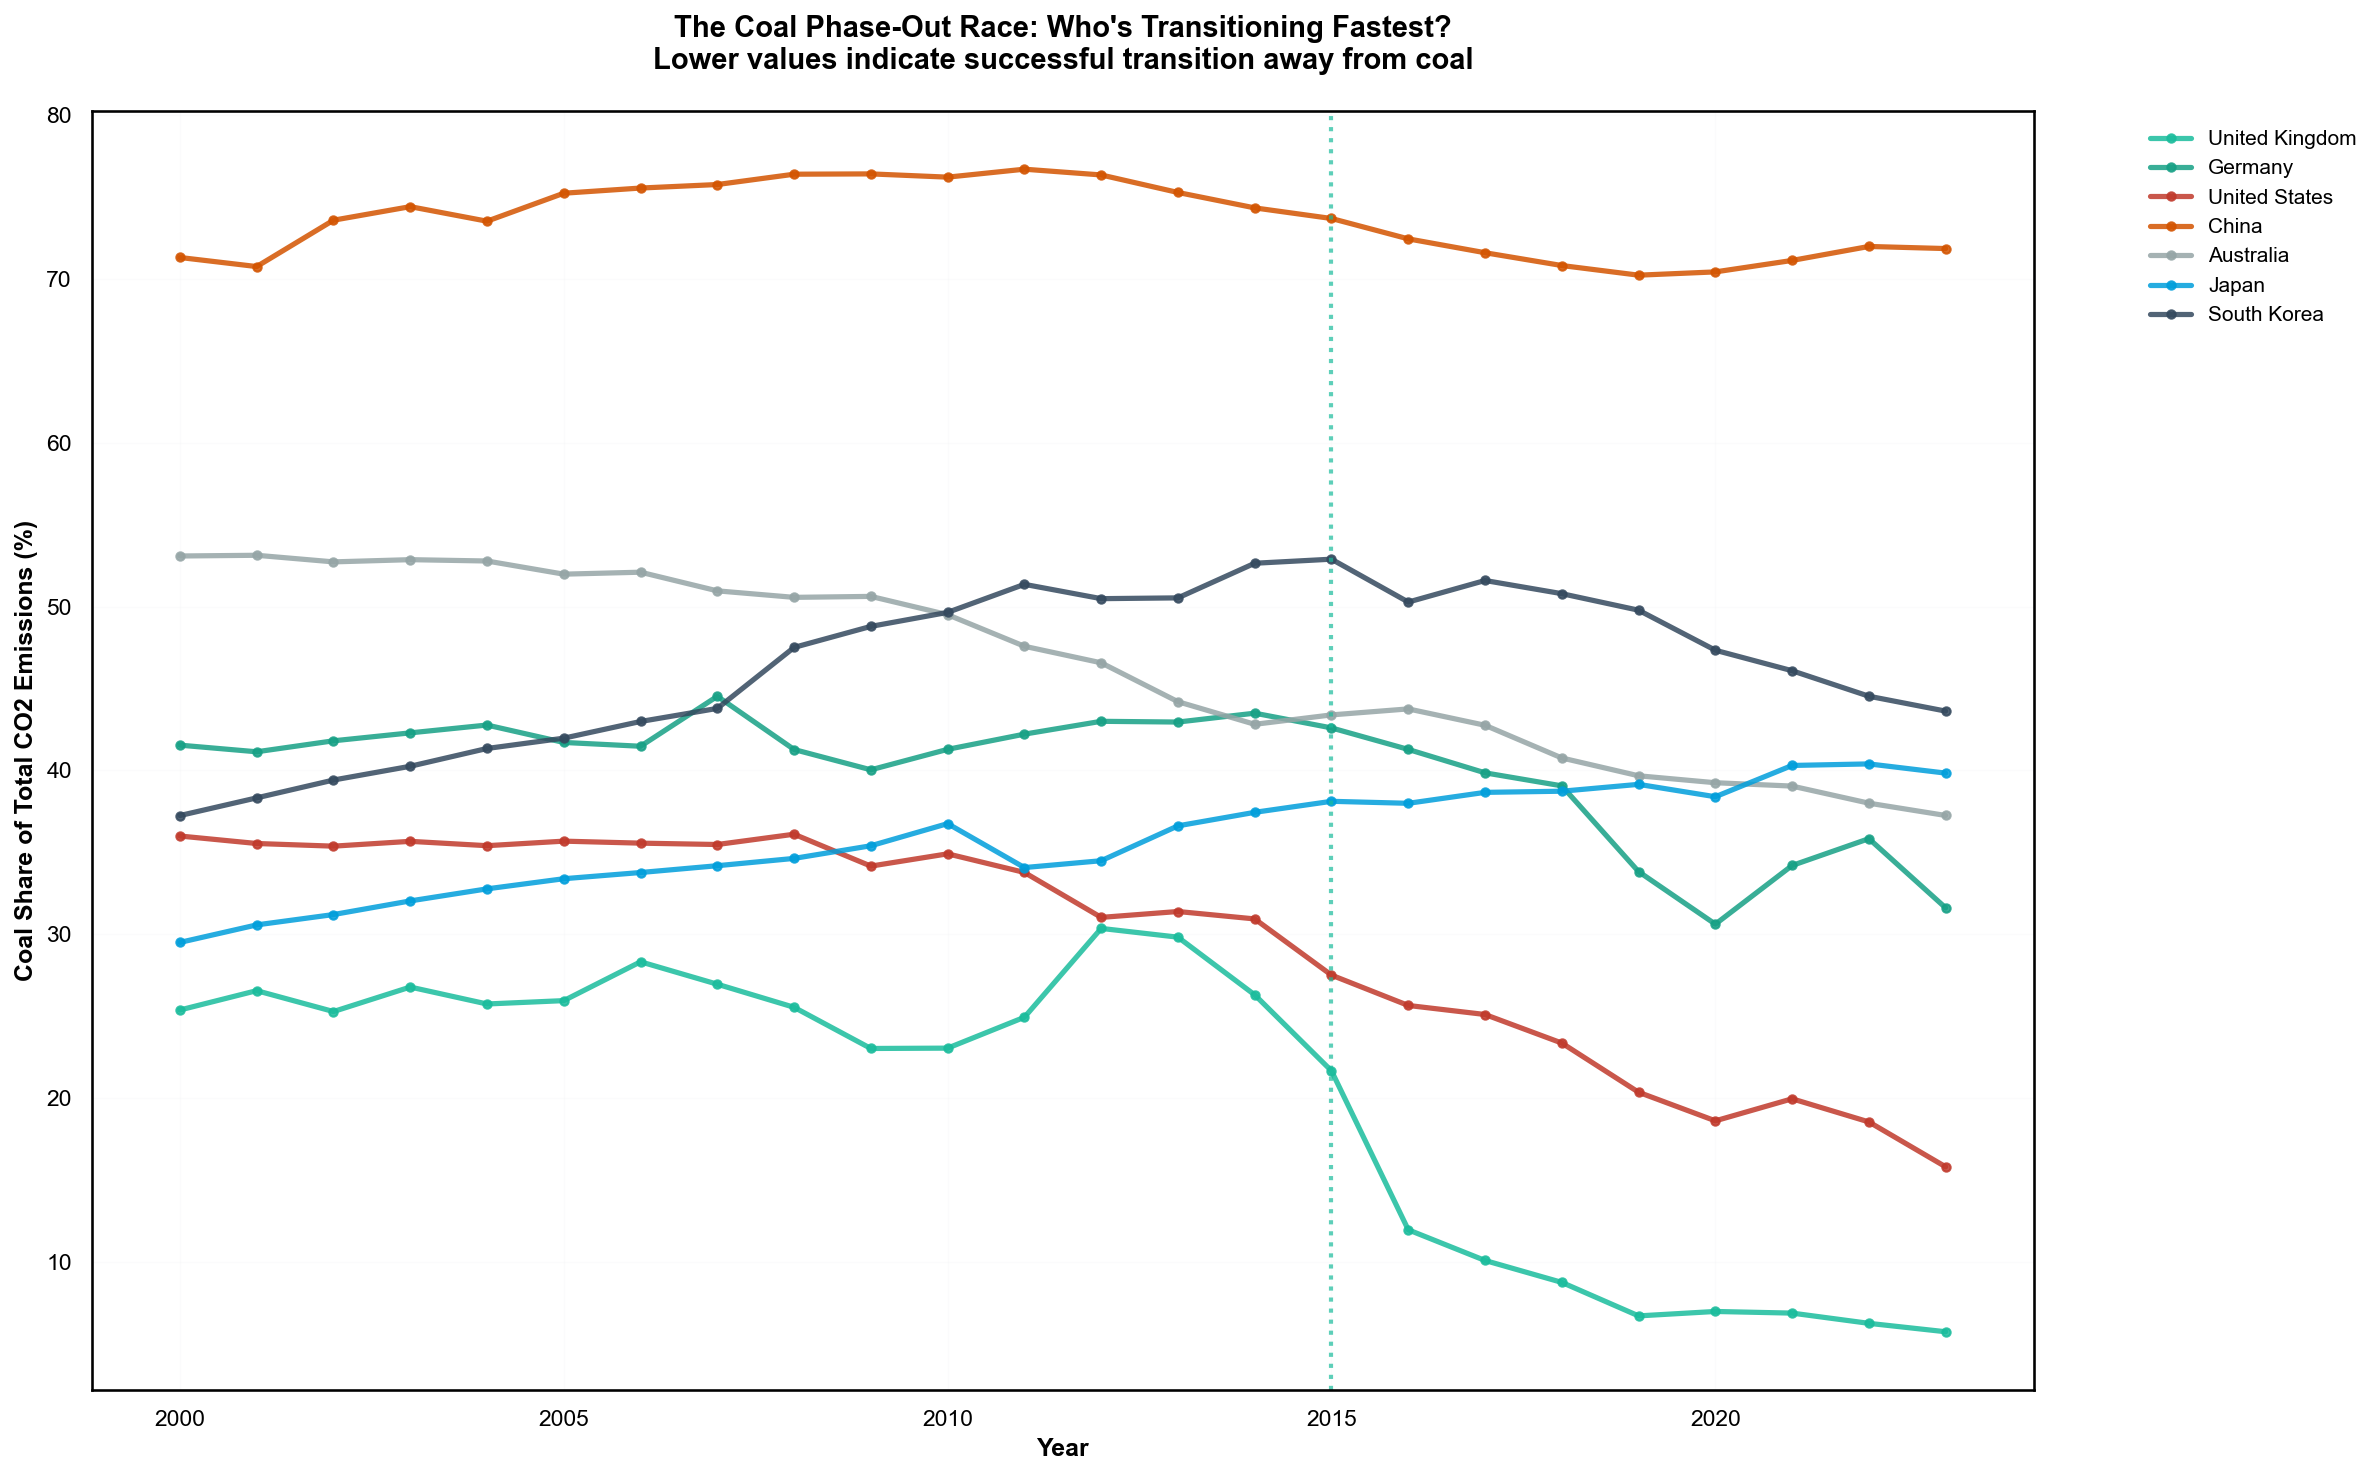

In [44]:
# Select countries known for coal transitions and major coal emitters
coal_countries = ['United Kingdom', 'Germany', 'United States', 'China'
                  , 'Australia', 'Japan', 'South Korea']

# Calculate coal share over time
coal_transition_data = []
for country in coal_countries:
    country_data = df[df['Country'] == country].copy()
    country_data = country_data[country_data['Year'] >= 2000].sort_values('Year')
    country_data['Coal_Share'] = (country_data['Coal CO2 Emissions'] / 
                                  country_data['CO2 Emissions'].replace(0, np.nan)) * 100
    coal_transition_data.append(country_data[['Country', 'Year', 'Coal_Share', 'Coal CO2 Emissions', 'CO2 Emissions']])

coal_transition = pd.concat(coal_transition_data, ignore_index=True)
coal_transition = coal_transition.dropna(subset=['Coal_Share'])

# Create line chart
fig, ax = plt.subplots(figsize=(16, 10))

# Define colors: Leaders (UK, Germany) in Teal shades, Heavy emitters (USA, China, India) in Rust/Orange
coal_country_colors = {
    'United Kingdom': UN_COLORS['lower_middle'],  # Teal - leader
    'Germany': '#16A085',  # Dark Teal - leader
    'United States': UN_COLORS['high_income'],  # Rust
    'China': UN_COLORS['negative'],  # Dark Orange
    'India': '#E67E22',  # Orange
    'Poland': UN_COLORS['upper_middle'],  # Mustard
    'Australia': '#95A5A6',  # Light Grey
    'South Africa': '#7F8C8D',  # Grey
    'Japan': UN_COLORS['un_blue'],  # UN Blue
    'South Korea': '#34495E'  # Dark Blue-Grey
}

for country in coal_countries:
    country_data = coal_transition[coal_transition['Country'] == country].sort_values('Year')
    if len(country_data) > 0:
        ax.plot(country_data['Year'], country_data['Coal_Share'], 
               marker='o', linewidth=2.5, label=country, alpha=0.85, markersize=4,
               color=coal_country_colors.get(country, UN_COLORS['slate_grey']))

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Coal Share of Total CO2 Emissions (%)', fontsize=12, fontweight='bold')
ax.set_title('The Coal Phase-Out Race: Who\'s Transitioning Fastest?\nLower values indicate successful transition away from coal', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, frameon=False)
ax.grid(True, alpha=0.2, color='#ECEFF1')
ax.axvline(x=2015, color=UN_COLORS['positive'], linestyle=':', linewidth=2, alpha=0.7, label='Paris Agreement')

plt.tight_layout()
plt.show()